## 1. Settings

### 1) Import libraries

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils_course

### 2) Hyperparameter

In [2]:
batch_size=16
learning_rate=0.0001
epoch=20

n_node=124
dropratio=0.5

imgsize=256

## 2. Data Loader

In [3]:
# train set

proj_dir='C:/Users/PRLAB/Desktop/nayeon/DL_course'
train='animal_dataset/train'
dev='animal_dataset/val'
test='animal_dataset/test'

train_data=dset.ImageFolder(os.path.join(proj_dir, train), transforms.Compose([
    transforms.CenterCrop(imgsize*2),
    transforms.RandomCrop(imgsize),
    transforms.RandomHorizontalFlip(),
    
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))

# dev data는 data augmentation하지 않음
dev_data=dset.ImageFolder(os.path.join(proj_dir, dev), transforms.Compose([
    transforms.CenterCrop(size=imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))

test_data=dset.ImageFolder(os.path.join(proj_dir, test), transforms.Compose([
    transforms.CenterCrop(size=imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))


train_batch=data.DataLoader(train_data, batch_size=batch_size,
                           shuffle=True, num_workers=2)
dev_batch=data.DataLoader(dev_data, batch_size=batch_size,
                           shuffle=False, num_workers=2)
test_batch=data.DataLoader(test_data, batch_size=batch_size,
                           shuffle=False, num_workers=2)

nclass=len(train_data.classes)
print("# of classes: %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
# print(dev_data.classes)
# print(test_data.classes)

print("\ntrain data 개수: ", train_data.__len__())
print("dev data 개수: ", dev_data.__len__())
print("test data 개수: ",test_data.__len__())

# of classes: 2
['cats', 'dogs']
{'cats': 0, 'dogs': 1}

train data 개수:  46
dev data 개수:  17
test data 개수:  41


## 3. Model

## 1) Pretrained VGG Model

In [4]:
vgg19=models.vgg19(pretrained=True)

for name, module in vgg19.named_children():
    print(name)

print(list(vgg19.children())[0])
print(list(vgg19.children())[-1])  # FC layer를 말함

features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

In [5]:
print(list(vgg19.children())[-1])

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


## 2) Customized Fully Model

In [6]:
base_dim=64
fsize=int(imgsize/32)

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG, self).__init__()
        self.layer0=nn.Sequential(*list(vgg19.children())[0])  # 앞부분만 사용
        
        # 뒷부분 FC layer는 만들어서 쓸거얌
        self.layer1=nn.Sequential(
            nn.Linear(8*base_dim*fsize*fsize, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, nclass)           
        )
        
        # weight initialization
        for m in self.layer1.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
    
    def forward(self, x): 
        out=self.layer0(x)
        out=out.view(out.size(0), -1)
        out=self.layer1(out)
        return out

## 3) Model on GPU

In [7]:
model=MyVGG().cuda()

for params in model.layer0.parameters():
    params.required_grad=False
    
for params in model.layer1.parameters():
    params.required_grad=True


C:\Users\PRLAB\.conda\envs\torch_hny\lib\site-packages\ipykernel_launcher.py:35: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [8]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## 4. Optimizer & Loss

In [9]:
import itertools

loss_func=nn.CrossEntropyLoss()
# optimizer=optim.Adam(model.layer1.parameters(), lr=learning_rate)

# optimizer=optim.Adam(itertools.chain(model.layer1.parameters(), model.layer2.parameters()), lr=learning_rate)
optimizer=optim.Adam(itertools.chain(model.layer0.parameters(), model.layer1.parameters()), lr=learning_rate)

## 5. Train

In [57]:
%run utils_course.py

ModuleNotFoundError: No module named 'sklearn'

In [58]:
def ComputeCorr(i_data_batch, i_model):  
    correct = 0
    total = 0
    for img, label in i_data_batch:
        torch.no_grad()
        #img = Variable(imgs, volatile=True).cuda()
        img = Variable(img).cuda()  # back prop. 안하고, forward prop. 만 하겠다.
        label = Variable(label).cuda()
        
        output = i_model(img)
        _, output_index = torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
    tmp = 100*correct/total
    tmp = (tmp.cpu()).data.numpy()
    #print("correct: %.2f" %tmp)
    
    return tmp

In [13]:
from utils_course import ComputeCorr

total_time=0
disp_step=10

to_train=True
if(to_train==False):
    netname='./nets/catdog_vgg19_10.pkl'
    model=torch.load(netname)
else:
    print("3 layer, n_node: %d, dropratio: %.2f" %(n_node, dropratio))
    model.eval()
    train_corr=utils_course.ComputeCorr(train_batch, model)
    dev_corr=utils_course.ComputeCorr(dev_batch, model)
    test_corr=utils_course.ComputeCorr(test_batch, model)
    
#     train_corr=ComputeCorr(train_batch, model)  # accuracy 계산
#     dev_corr=ComputeCorr(dev_batch, model)
#     test_corr=ComputeCorr(test_batch, model)
    
    print("Correct of train: %.2f, dev: %.2f, test: %.2f"
         %(train_corr, dev_corr, test_corr))
    model.train()
    
    
    netname='./nets/catdog_vgg19'
    # graph 그리기
    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []

    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)  # 100-accuracy=error
    y_dev_err.append(100.0-train_corr)
    y_test_err.append(100.0-train_corr)
    
    # 학습을 재시작한다면
#     netname='../nets/media_pre_vgg19.pkl'
#     model=torch.load(netname)
#     # 파라미터 학습 여부 결정
#     for params in model.layer0.parameters():
#         params.required_grad=False
#     for params in model.layer1.parameters():
#         params.required_grad=True
#     for i in range(34, epoch):
    
    
    # 재시작하지 않는다면
    for i in range(epoch):
        start_time=time.time()
        print("%d.." %i)
        # 배치사이즈만큼 이미지, 레이블을 떼서 학습시키기
        for img, label in train_batch:
            img=Variable(img).cuda()
            label=Variable(label).cuda()
            
            optimizer.zero_grad()
            output=model(img)
            loss=loss_func(output, label)
            loss.backward()  # gradient 계산
            optimizer.step()  # 갱신
            
            
        end_time=time.time()
        duration=end_time - start_time
        total_time+=duration
        if (i % disp_step ==0) or (i==epoch-1):
            torch.save(model, netname+'_%d.pkl'%i)
            print("\n[%d%d] loss: %.3f, "%(i, epoch, (loss.cpu()).data.numpy()))
            
            # train, dev, test accuracy
            model.eval()
            train_corr=utils_course.ComputeCorr(train_batch, model)
            dev_corr=utils_course.ComputeCorr(dev_batch, model)
            test_corr=utils_course.ComputeCorr(test_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f"
                 %(train_corr, dev_corr, test_corr))
            model.train()
            print("time: %.2f sec.." %(total_time))

            # graph 그리기
            x_epoch.append(i+1)
            y_train_err.append(100.0 - train_corr)
            y_dev_err.append(100.0 - dev_corr)
            y_test_err.append(100.0 - test_corr)
        print("Total time: %.2f sec" %total_time)

3 layer, n_node: 124, dropratio: 0.50
Correct of train: 84.78, dev: 70.59, test: 97.56
0..

[020] loss: 0.661, 
Correct of train: 100.00, dev: 70.59, test: 97.56
time: 8.48 sec..
Total time: 8.48 sec
1..
Total time: 15.37 sec
2..
Total time: 21.81 sec
3..
Total time: 31.08 sec
4..
Total time: 40.97 sec
5..
Total time: 51.58 sec
6..
Total time: 60.49 sec
7..
Total time: 67.40 sec
8..
Total time: 77.23 sec
9..
Total time: 84.14 sec
10..

[1020] loss: 0.639, 
Correct of train: 93.48, dev: 88.24, test: 92.68
time: 90.97 sec..
Total time: 90.97 sec
11..
Total time: 98.53 sec
12..
Total time: 103.84 sec
13..
Total time: 111.33 sec
14..
Total time: 122.64 sec
15..
Total time: 132.27 sec
16..
Total time: 141.32 sec
17..
Total time: 150.77 sec
18..
Total time: 160.60 sec
19..

[1920] loss: 0.646, 
Correct of train: 91.30, dev: 76.47, test: 92.68
time: 170.80 sec..
Total time: 170.80 sec


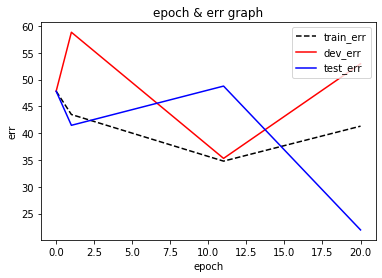

In [62]:
# epoch-error curve

if (to_train):
    plt.plot(x_epoch, y_train_err, color='black', label='train_err', linestyle='--')
    plt.plot(x_epoch, y_dev_err, color='red', label='dev_err')
    plt.plot(x_epoch, y_test_err, color='blue', label='test_err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc="upper right")
    plt.show()

## 6. Evaluation for dev & test data

In [63]:
def EvaluateClassifier(i_batch, i_model, i_classes, i_batch_size=32):
    # --- 1. Confusion matrix 그리기 ---
    # 1) pred, true 배열 구하기
    # 전체 길이 계산
    n = 0
    for i, [imgs, _] in enumerate(i_batch):
        n += len(imgs)    
    
    pred_1d, label_1d, prob_1d, prob_2d = ComputePredProb(i_batch, i_model, i_classes, i_batch_size)
    
    # 2) confusion matrix 계산
    #print("size of pred: %d, true: %d" %(len(pred_1d), len(label_1d)))
    cnf_mat = confusion_matrix(label_1d, pred_1d)
    #del pred_1d, label_1d

    plt.figure()
    plot_confusion_matrix(cnf_mat, classes=i_classes, normalize=True, title='Normalized confusion matrix')
    plt.show()

    plt.figure()
    plot_confusion_matrix(cnf_mat, classes=i_classes, title='Confusion matrix, without normalization')
    plt.show()

    # --- 2. Accr, F1, Precision, Recall ---
    matric4classifer(cnf_mat, i_classes)
    
    # --- 3. mAP(mean average precision ---
    # aps: 각 클래스의 AP
    # o_mAP: 모든 AP의 평균
    o_mAP, aps = mAP(prob_2d, label_1d, i_classes)
    
    # --- 4. imAP(image mean average precision) ---
    o_imAP, iaps = imAP(prob_2d, label_1d)
    
    return pred_1d, label_1d, prob_1d

In [66]:
from utils_course import EvaluateClassifier

ModuleNotFoundError: No module named 'sklearn'

In [64]:
model.eval()
EvaluateClassifier(dev_batch, dev_data.classes, batch_size)

TypeError: object of type 'int' has no len()

In [65]:
model.eval()
_, _, _=EvaluateClassifier(test_batch, test_data.classes, batch_size)

TypeError: object of type 'int' has no len()

In [ ]:
utils.VisTFPred(dev_batch, model, test_data.classes, batch_size, i_n=2)